# Regressão Logística (binária) — do zero com NumPy

**Objetivo:** implementar e entender a regressão logística **sem scikit-learn**, usando apenas **NumPy** e **matplotlib** para visualização.  
A estrutura e o estilo seguem o *notebook* de Regressão Linear deste projeto (docstrings em PT‑BR, funções utilitárias, seção de visualização e exemplos com dados sintéticos).

> **Quando usar:** classificação binária `y ∈ {0,1}`.  
> **O que você verá:** intuição, equações, implementação, métricas, regularização, ajuste de limiar e curvas ROC.

---

## 1. Intuição e fórmulas essenciais

### 1.1. Modelo
Dado um vetor de atributos $x_i \in \mathbb{R}^p$ (com intercepto), modelamos a **probabilidade** de $y_i=1$ via a função **sigmoide**:
$$
p_i = \Pr(y_i = 1 \mid x_i) = \sigma(z_i), \quad z_i = x_i^\top \beta, \quad 
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

A **odds** (razão de chances) e o **logit** (log‑odds) são
$$
\text{odds} = \frac{p}{1-p}, \qquad \log\frac{p}{1-p} = x^\top \beta.
$$

### 1.2. Função de custo (log‑loss / entropia cruzada)
$$
J(\beta) 
= -\frac{1}{n}\sum_{i=1}^{n}\big[y_i\log p_i + (1-y_i)\log(1-p_i)\big]
\;+\; \frac{\lambda}{2n}\,\|\tilde\beta\|_2^2,
$$
onde $\tilde\beta$ **não** inclui o intercepto (não penalizamos a 1ª coordenada).

### 1.3. Gradiente e Hessiana
Denote $p = \sigma(X\beta)$ (vetor $n\times1$).
$$
\nabla J(\beta) = \frac{1}{n}X^\top (p - y) + \frac{\lambda}{n}\,\tilde\beta,
$$
$$
H(\beta) = \frac{1}{n}X^\top W X + \frac{\lambda}{n}\,\tilde I, \quad 
W = \operatorname{diag}(p\odot(1-p)).
$$

### 1.4. Decisão e limiar
A predição final usa um **limiar** $t\in(0,1)$:
$$
\hat y_i = \mathbb{1}\{p_i \ge t\}.
$$
- $t=0.5$ é comum, mas nem sempre ótimo (p. ex., classes desbalanceadas).
- Ajustar $t$ permite priorizar *recall* vs *precision* conforme o problema.

## 2. Implementação (NumPy)

Abaixo estão utilitários e algoritmos de otimização (gradiente e Newton) com regularização L2 opcional.  
As funções são autocontidas e documentadas, para estudo e reuso.

In [1]:
import numpy as np

# -----------------------------
# Utilitários gerais
# -----------------------------
def add_intercept(X):
    """
    Garante a coluna de 1s para o intercepto.
    Aceita vetor (n,) ou matriz (n, p) e retorna matriz (n, p+1).
    """
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    n = X.shape[0]
    return np.hstack([np.ones((n, 1)), X])

def standardize(X, ddof=0):
    """
    Padroniza cada coluna (exceto a de intercepto) para média 0 e desvio 1.
    Retorna X_std, medias, desvios (para reverter em produção, se necessário).
    """
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    mu = X.mean(axis=0)
    sd = X.std(axis=0, ddof=ddof)
    sd_safe = np.where(sd == 0, 1.0, sd)
    Xs = (X - mu) / sd_safe
    return Xs, mu, sd_safe

def train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True):
    """
    Divide X e y em treino e teste preservando a correspondência linha-a-linha.
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)
    n_test = int(np.floor(test_size * n))
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# -----------------------------
# Núcleo matemático
# -----------------------------
def sigmoid(z):
    """
    Sigmoide numericamente estável.
    """
    z = np.asarray(z)
    # Estabilidade: clip para evitar overflow em exp
    z_clip = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z_clip))

def predict_proba(X, beta):
    """
    Retorna p = Pr(y=1|X) como vetor (n,).
    """
    return sigmoid(X @ beta)

def predict_label(X, beta, threshold=0.5):
    """
    Retorna rótulos binários com base em um limiar.
    """
    p = predict_proba(X, beta)
    return (p >= threshold).astype(int)

def bce_loss(y, p, l2=0.0, beta=None, penalize_intercept=False):
    """
    Log-loss (entropia cruzada) média com regularização L2 opcional.
    y: (n,), p: (n,)
    l2: lambda de regularização
    beta: necessário se l2 > 0
    """
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    base = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    if l2 > 0 and beta is not None:
        if penalize_intercept:
            reg = 0.5 * l2 * np.mean(beta**2)
        else:
            reg = 0.5 * l2 * np.mean(beta[1:]**2)
        return base + reg
    return base

def gradient(X, y, beta, l2=0.0, penalize_intercept=False):
    """
    ∇J(β) = (1/n) X^T (p - y) + (λ/n) * β̃
    """
    n = len(y)
    p = predict_proba(X, beta)
    grad = (X.T @ (p - y)) / n
    if l2 > 0:
        if penalize_intercept:
            reg = (l2 / n) * beta
        else:
            reg = (l2 / n) * np.r_[0.0, beta[1:]]
        grad = grad + reg
    return grad

def hessian(X, beta, l2=0.0, penalize_intercept=False):
    """
    H(β) = (1/n) X^T W X + (λ/n) * Ĩ, com W = diag(p*(1-p)).
    """
    n = X.shape[0]
    p = predict_proba(X, beta)
    w = p * (1 - p)
    # X^T W X sem formar W explicitamente
    Xw = X * w[:, None]
    H = (X.T @ Xw) / n
    if l2 > 0:
        if penalize_intercept:
            H = H + (l2 / n) * np.eye(X.shape[1])
        else:
            H = H + (l2 / n) * np.diag(np.r_[0.0, np.ones(X.shape[1] - 1)])
    return H

# -----------------------------
# Otimizadores
# -----------------------------
def logistic_gd(X, y, l2=0.0, lr=0.1, n_iter=2000, beta0=None, tol=1e-8, penalize_intercept=False, return_history=True, verbose=False):
    """
    Gradiente descendente em lote para regressão logística.
    Retorna (beta, history) se return_history=True, caso contrário apenas beta.
    """
    n, d = X.shape
    beta = np.zeros(d) if beta0 is None else beta0.astype(float).copy()
    history = []
    for i in range(n_iter):
        p = predict_proba(X, beta)
        loss = bce_loss(y, p, l2=l2, beta=beta, penalize_intercept=penalize_intercept)
        g = gradient(X, y, beta, l2=l2, penalize_intercept=penalize_intercept)
        beta_new = beta - lr * g
        if return_history:
            history.append(loss)
        if np.linalg.norm(beta_new - beta) < tol:
            beta = beta_new
            if verbose:
                print(f"Parou por tolerância no passo {i}.")
            break
        beta = beta_new
    return (beta, np.array(history)) if return_history else beta

def logistic_newton(X, y, l2=0.0, n_iter=100, beta0=None, tol=1e-8, penalize_intercept=False, return_history=True, verbose=False):
    """
    Método de Newton (IRLS) para regressão logística.
    """
    n, d = X.shape
    beta = np.zeros(d) if beta0 is None else beta0.astype(float).copy()
    history = []
    for i in range(n_iter):
        p = predict_proba(X, beta)
        loss = bce_loss(y, p, l2=l2, beta=beta, penalize_intercept=penalize_intercept)
        g = gradient(X, y, beta, l2=l2, penalize_intercept=penalize_intercept)
        H = hessian(X, beta, l2=l2, penalize_intercept=penalize_intercept)
        try:
            step = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            # fallback: gradiente com passo pequeno
            step = g
        beta_new = beta - step
        if return_history:
            history.append(loss)
        if np.linalg.norm(beta_new - beta) < tol:
            beta = beta_new
            if verbose:
                print(f"Parou por tolerância no passo {i}.")
            break
        beta = beta_new
    return (beta, np.array(history)) if return_history else beta

# -----------------------------
# Métricas e avaliação
# -----------------------------
def confusion_matrix(y_true, y_pred):
    """
    Retorna a matriz 2x2 [[tn, fp],[fn, tp]].
    """
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    return np.array([[tn, fp], [fn, tp]])

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1,1]; fp = cm[0,1]
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def recall(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1,1]; fn = cm[1,0]
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def f1_score(y_true, y_pred):
    pr = precision(y_true, y_pred)
    rc = recall(y_true, y_pred)
    return 2*pr*rc/(pr+rc) if (pr+rc) > 0 else 0.0

def roc_curve_points(y_true, scores):
    """
    Curva ROC: retorna (fpr, tpr, thresholds) varrendo do maior para o menor score.
    """
    # Ordena por score desc
    order = np.argsort(-scores)
    y = y_true[order]
    scores_sorted = scores[order]
    # Todos limiares únicos (e extremos)
    thresholds = np.r_[np.inf, np.unique(scores_sorted)[::-1], -np.inf]
    tpr = []; fpr = []
    P = np.sum(y == 1)
    N = np.sum(y == 0)
    for t in thresholds:
        y_pred = (scores_sorted >= t).astype(int)
        tp = np.sum((y == 1) & (y_pred == 1))
        fp = np.sum((y == 0) & (y_pred == 1))
        tpr.append(tp / P if P > 0 else 0.0)
        fpr.append(fp / N if N > 0 else 0.0)
    return np.array(fpr), np.array(tpr), thresholds

def auc_trapezoid(x, y):
    """
    AUC usando regra do trapézio. x deve estar em ordem crescente.
    """
    # Garante que x está crescente
    order = np.argsort(x)
    x = x[order]; y = y[order]
    return np.trapz(y, x)

# -----------------------------
# Validação cruzada simples
# -----------------------------
def kfold_indices(n, k=5, random_state=0, shuffle=True):
    rng = np.random.default_rng(random_state)
    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)
    folds = np.array_split(idx, k)
    return folds

def crossval_logistic(X, y, l2_list, k=5, use_newton=True, lr=0.1, n_iter=2000, random_state=0):
    """
    Faz k-fold CV para escolher l2 que minimiza log-loss.
    Retorna l2_best, losses_medias_por_lambda (dict).
    """
    n = len(y)
    folds = kfold_indices(n, k=k, random_state=random_state, shuffle=True)
    losses = {lam: [] for lam in l2_list}
    for lam in l2_list:
        for i in range(k):
            valid_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(k) if j != i])
            Xtr, ytr = X[train_idx], y[train_idx]
            Xva, yva = X[valid_idx], y[valid_idx]
            if use_newton:
                beta, hist = logistic_newton(Xtr, ytr, l2=lam, n_iter=100, return_history=True)
            else:
                beta, hist = logistic_gd(Xtr, ytr, l2=lam, lr=lr, n_iter=n_iter, return_history=True)
            pva = predict_proba(Xva, beta)
            losses[lam].append(bce_loss(yva, pva))
    losses_mean = {lam: float(np.mean(v)) for lam, v in losses.items()}
    l2_best = min(losses_mean, key=losses_mean.get)
    return l2_best, losses_mean

## 3. Funções de visualização (matplotlib)

As rotinas abaixo ajudam a **inspecionar** o treinamento e a **diagnosticar** o modelo.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sigmoid():
    xs = np.linspace(-10, 10, 400)
    ys = 1/(1+np.exp(-xs))
    plt.figure()
    plt.plot(xs, ys)
    plt.title("Função sigmoide")
    plt.xlabel("z")
    plt.ylabel("σ(z)")
    plt.grid(True)
    plt.show()

def plot_learning_curve(history, title="Curva de aprendizagem (log-loss)"):
    plt.figure()
    plt.plot(np.arange(len(history)), history)
    plt.title(title)
    plt.xlabel("iteração")
    plt.ylabel("log-loss")
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(cm, labels=("0","1")):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title("Matriz de confusão")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    # anotações
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i,j]), ha="center", va="center")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, scores):
    fpr, tpr, thr = roc_curve_points(y_true, scores)
    auc = auc_trapezoid(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title("Curva ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid(True)
    plt.show()
    return auc

def plot_decision_boundary(X2d, y, beta, pad=0.5, h=0.02):
    """
    Apenas para visualização em 2D (duas features).
    X2d: matriz (n,2) sem intercepto; a função adicionará internamente.
    """
    x_min, x_max = X2d[:,0].min() - pad, X2d[:,0].max() + pad
    y_min, y_max = X2d[:,1].min() - pad, X2d[:,1].max() + pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Xg = add_intercept(grid)
    Z = predict_label(Xg, beta).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X2d[:,0], X2d[:,1], c=y)
    plt.title("Fronteira de decisão")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

## 4. Exemplos de uso (dados sintéticos)

Nesta seção treinamos e avaliamos modelos em dados simulados controláveis:

- **Blobs gaussianos** (classes parcialmente separáveis);
- **Desbalanceamento de classes** (ajuste de limiar);
- **Regularização L2** (evita overfitting e estabiliza estimação).

> Ajuste os hiperparâmetros (taxa de aprendizado, iterações, λ) e observe os efeitos.

β (GD): [-0.0876288   2.17962789  1.93234146]
log-loss treino=0.2850  teste=0.2120
accuracy treino=0.886  teste=0.908


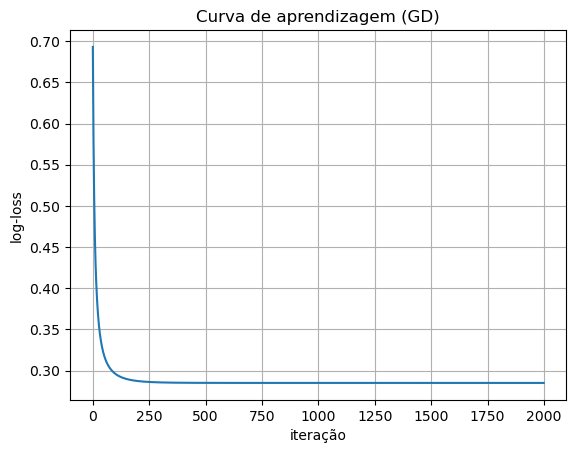

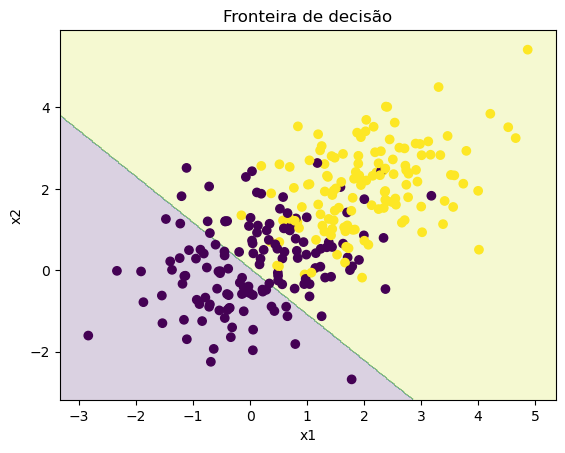

Matriz de confusão (teste):
 [[52  2]
 [ 9 57]]


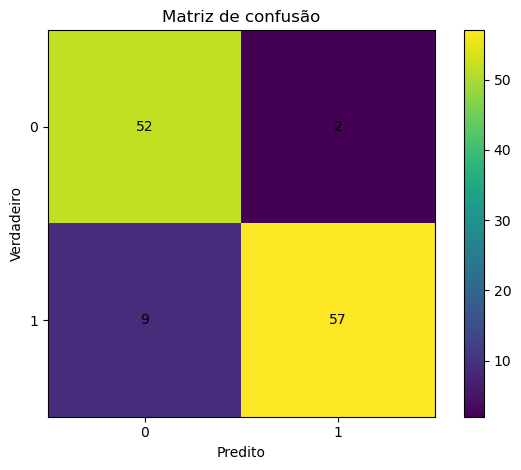

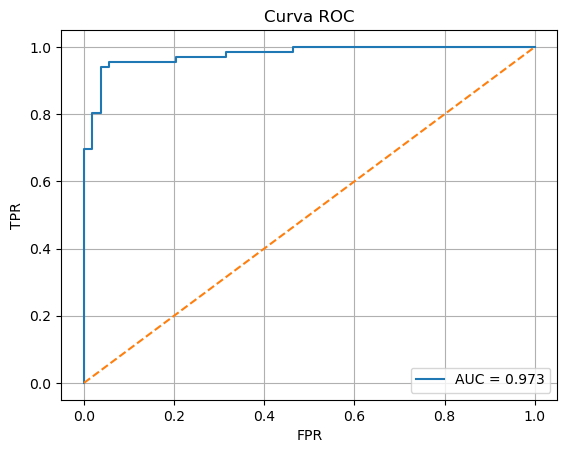

AUC (teste): 0.973


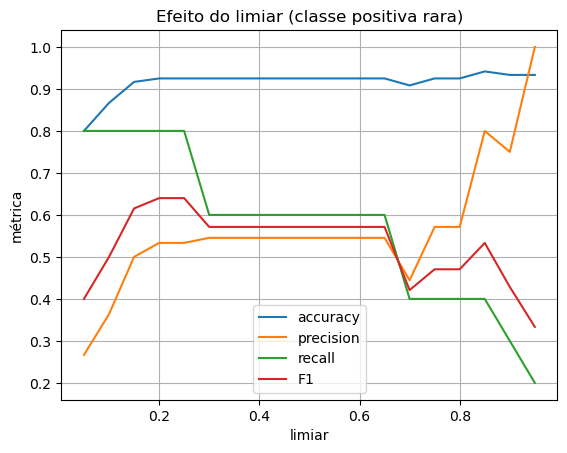

Validação cruzada (log-loss médio por λ): {0.0: 0.3000714945252858, 0.01: 0.30001208081700576, 0.1: 0.2995376418749438, 1.0: 0.2983108275438697, 10.0: 0.32768373872001033}
Melhor λ: 1.0
accuracy (λ*): 0.9083333333333333


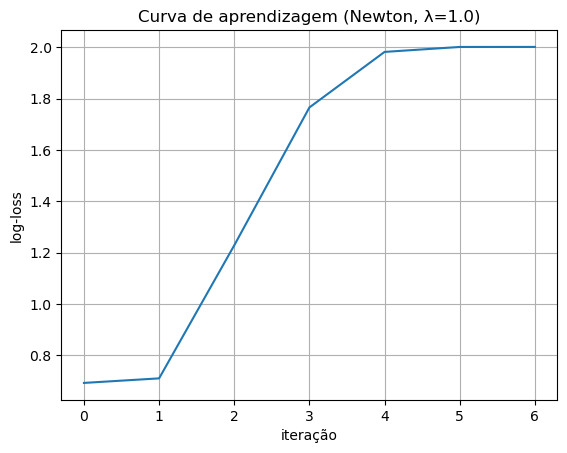

In [3]:
import numpy as np

# ----- 4.1 Gerando dados 2D (duas features) -----
rng = np.random.default_rng(0)
n0, n1 = 200, 200  # quantos pontos por classe
mean0 = np.array([0.0, 0.0])
mean1 = np.array([2.0, 2.0])
cov = np.array([[1.0, 0.3],
                [0.3, 1.0]])
X0 = rng.multivariate_normal(mean0, cov, size=n0)
X1 = rng.multivariate_normal(mean1, cov, size=n1)
X = np.vstack([X0, X1])
y = np.r_[np.zeros(n0, dtype=int), np.ones(n1, dtype=int)]

# Padroniza as features (boas práticas) e adiciona intercepto
X_std, mu, sd = standardize(X)
X_full = add_intercept(X_std)

# Divide treino/teste
Xtr, Xte, ytr, yte = train_test_split(X_full, y, test_size=0.3, random_state=42)

# ----- 4.2 Treinando com GD -----
beta_gd, hist_gd = logistic_gd(Xtr, ytr, l2=0.0, lr=0.2, n_iter=2000, return_history=True)
print("β (GD):", beta_gd)

# Avaliação
ptr = predict_proba(Xtr, beta_gd)
pte = predict_proba(Xte, beta_gd)
yhat_tr = (ptr >= 0.5).astype(int)
yhat_te = (pte >= 0.5).astype(int)

loss_tr = bce_loss(ytr, ptr)
loss_te = bce_loss(yte, pte)
acc_tr  = accuracy(ytr, yhat_tr)
acc_te  = accuracy(yte, yhat_te)
print(f"log-loss treino={loss_tr:.4f}  teste={loss_te:.4f}")
print(f"accuracy treino={acc_tr:.3f}  teste={acc_te:.3f}")

# Curva de aprendizagem
plot_learning_curve(hist_gd, title="Curva de aprendizagem (GD)")

# Fronteira de decisão no espaço 2D original (não padronizado)
# (apenas para desenhar, usamos as features sem intercepto)
# Reconstrói X2d de treino e teste sem intercepto
Xtr_2d = (Xtr[:,1:] * sd) + mu
Xte_2d = (Xte[:,1:] * sd) + mu

plot_decision_boundary(Xtr_2d, ytr, beta_gd)

# Matriz de confusão e ROC (teste)
cm = confusion_matrix(yte, yhat_te)
print("Matriz de confusão (teste):\n", cm)
plot_confusion_matrix(cm, labels=("0","1"))
auc = plot_roc(yte, pte)
print(f"AUC (teste): {auc:.3f}")

# ----- 4.3 Ajuste de limiar sob desbalanceamento -----
# Deixa a classe 1 mais rara (e.g., 10%)
ratio = 0.1
n1_new = int(ratio * (n0 + n1))
n0_new = (n0 + n1) - n1_new
X0b = rng.multivariate_normal(mean0, cov, size=n0_new)
X1b = rng.multivariate_normal(mean1, cov, size=n1_new)
Xb = np.vstack([X0b, X1b])
yb = np.r_[np.zeros(n0_new, dtype=int), np.ones(n1_new, dtype=int)]
Xb_std, mu_b, sd_b = standardize(Xb)
Xb_full = add_intercept(Xb_std)
Xtr_b, Xte_b, ytr_b, yte_b = train_test_split(Xb_full, yb, test_size=0.3, random_state=7)

beta_b, hist_b = logistic_gd(Xtr_b, ytr_b, lr=0.2, n_iter=2000, return_history=True)
pte_b = predict_proba(Xte_b, beta_b)

# Varia limiar e calcula métricas
thresholds = np.linspace(0.05, 0.95, 19)
accs = []; precs = []; recs = []; f1s = []
for t in thresholds:
    yhat = (pte_b >= t).astype(int)
    accs.append(accuracy(yte_b, yhat))
    precs.append(precision(yte_b, yhat))
    recs.append(recall(yte_b, yhat))
    f1s.append(f1_score(yte_b, yhat))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(thresholds, accs, label="accuracy")
plt.plot(thresholds, precs, label="precision")
plt.plot(thresholds, recs, label="recall")
plt.plot(thresholds, f1s, label="F1")
plt.title("Efeito do limiar (classe positiva rara)")
plt.xlabel("limiar")
plt.ylabel("métrica")
plt.legend()
plt.grid(True)
plt.show()

# ----- 4.4 Regularização L2 + validação cruzada -----
lambdas = [0.0, 0.01, 0.1, 1.0, 10.0]
l2_best, loss_mean = crossval_logistic(Xtr, ytr, lambdas, k=5, use_newton=True, random_state=123)
print("Validação cruzada (log-loss médio por λ):", loss_mean)
print("Melhor λ:", l2_best)

# Reajusta com λ ótimo (Newton) e avalia
beta_cv, hist_cv = logistic_newton(Xtr, ytr, l2=l2_best, n_iter=50, return_history=True)
pte_cv = predict_proba(Xte, beta_cv)
yhat_cv = (pte_cv >= 0.5).astype(int)
print("accuracy (λ*):", accuracy(yte, yhat_cv))
plot_learning_curve(hist_cv, title=f"Curva de aprendizagem (Newton, λ={l2_best})")

## 5. Dicas e referências rápidas

- **Interpretação de coeficientes**: um aumento de 1 unidade em $x_j$ (mantendo os demais fixos) multiplica a **odds** por $e^{\beta_j}$.
- **Regularização**: em presença de colinearidade ou separação quase perfeita, a penalização L2 (ou L1) estabiliza o ajuste.
- **Limiar**: ajuste o limiar conforme os *trade-offs* de negócio (falsos positivos vs falsos negativos).
- **Escala**: padronize as features; melhora a convergência e a interpretação do intercepto.